In [118]:
#from time import time
import numpy as np
import matplotlib.pyplot as plt

# Establish redis connection

In [151]:
import redis

if __name__ == "__main__":
    r = redis.Redis(host="192.168.99.100",port=6379)
    
    r.set("check","connection")
    print("Check ",r.get("check"))

Check  b'connection'


In [152]:
r = redis.Redis(host="192.168.99.100",port=6379)

# Test job size vs job time

In [311]:
N = 1000

memory_set = {}
memory_get = {}

time_table_set = {}
time_table_get = {}

time_complete_set = {}
time_complete_get = {}



# memory issues around size 256 ... 
# 9 
array_sizes = 2**np.arange(9)
for size in array_sizes:
    
    print("size {}".format(size**2 * 8))
    t_set = []
    t_get = []
    t_set_complete = []
    t_get_complete =[]
    
    # store values
    
    
    for i in range(N):

        t_start = r.time()
        
        key = "{0:015b}".format(i)
        x = np.random.uniform(0,1,size=(size,size))
        r.set(key,x.tobytes())

        t_end = r.time()
        
        job_time = (t_end[0] + t_end[1]*1e-6)-(t_start[0] + t_start[1]*1e-6)
        
        
        t_set.append(job_time)
        t_set_complete.append(t_end[0] + t_end[1]*1e-6)

        
        
    # get values
    for i in range(N):

        t_start = r.time()
        
        key = "{0:015b}".format(i)
        r.get(key)
        
        t_end =  r.time()
        
        job_time = (t_end[0] + t_end[1]*1e-6)-(t_start[0] + t_start[1]*1e-6)
        
        t_get.append(job_time)
        t_get_complete.append(t_end[0] + t_end[1]*1e-6)

        
    # clear keys
    for i in range(N):
        r.delete("{0:015b}".format(i))
    
    memory_set[str(size**2 * 8)] = np.mean(t_set)
    time_table_set[str(size**2 * 8)] = t_set
    
    memory_get[str(size**2 * 8)] = np.mean(t_get)
    time_table_get[str(size**2 * 8)] = t_get
    
    time_complete_set[str(size**2 * 8)] = time_complete_set
    time_complete_get[str(size**2 * 8)] = time_complete_get
    

size 8
size 32
size 128
size 512
size 2048
size 8192
size 32768
size 131072
size 524288


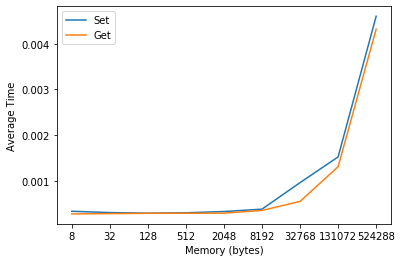

In [314]:
plt.plot(np.array(list(memory_set.keys())),np.array(list(memory_set.values())))
plt.plot(np.array(list(memory_get.keys())),np.array(list(memory_get.values())))
plt.xlabel("Memory (bytes)")
plt.ylabel("Average Time")
plt.legend(["Set","Get"])

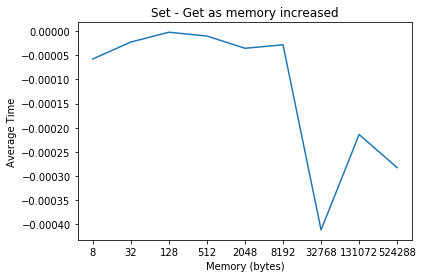

In [320]:
plt.plot(np.array(list(memory_get.keys())),np.array(list(memory_get.values()))-np.array(list(memory_set.values())))
plt.xlabel("Memory (bytes)")
plt.ylabel("Average Time")
plt.title("Set - Get as memory increased")
plt.show()

C:\Users\lpott\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  # Remove the CWD from sys.path while we load stuff.


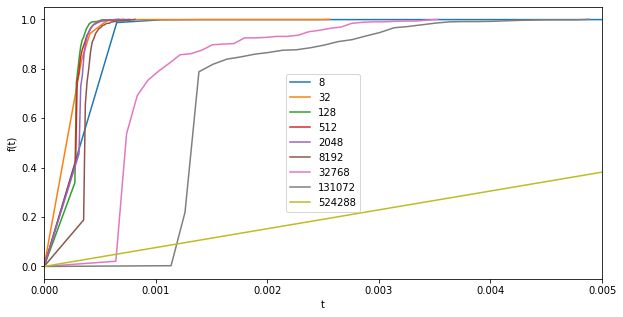

In [316]:
plt.figure(figsize=(10,5))


for size in array_sizes:
    key = size**2 * 8
    
    t = time_table_set[str(key)]

    num_bins = int(np.sqrt(len(t)))#int(np.floor(5/3 * (len(t)**(1/3))))
    counts, bin_edges = np.histogram (t, bins=num_bins, normed=True)
    cdf = np.cumsum (counts)
    plt.plot (np.hstack((np.zeros((1,)),bin_edges[1:])), np.hstack((np.zeros(1,),cdf/cdf[-1])))
    plt.xlabel("t"); plt.ylabel("f(t)");
    
    

plt.xlim([0,0.005])
plt.legend(array_sizes**2 * 8)
plt.show()


C:\Users\lpott\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  # Remove the CWD from sys.path while we load stuff.


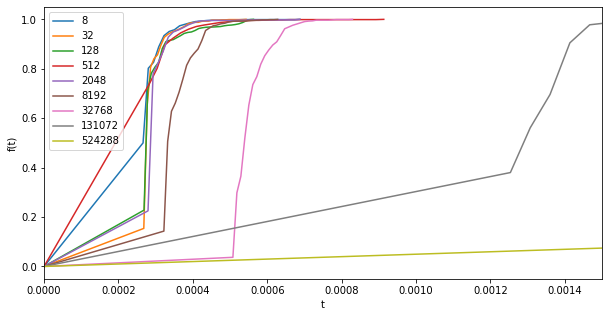

In [318]:
plt.figure(figsize=(10,5))


for size in array_sizes:
    key = size**2 * 8
    
    t = time_table_get[str(key)]

    num_bins = int(np.sqrt(len(t)))#int(np.floor(5/3 * (len(t)**(1/3))))
    counts, bin_edges = np.histogram (t, bins=num_bins, normed=True)
    cdf = np.cumsum (counts)
    plt.plot (np.hstack((np.zeros((1,)),bin_edges[1:])), np.hstack((np.zeros(1,),cdf/cdf[-1])))
    plt.xlabel("t"); plt.ylabel("f(t)");
    
    

plt.xlim([0,0.0015])
plt.legend(array_sizes**2 * 8)
plt.show()

In [322]:
# clear keys
for i in range(N):
    r.delete("{0:015b}".format(i))

#  \#job vs total time

In [323]:
N = 100

memory_set = {}
memory_get = {}

time_table_set = {}
time_table_get = {}

time_complete_set = {}
time_complete_get = {}

pipeline = r.pipeline(transaction=True)


job_size = np.array([1,10,100,1000,10000,100000])

for size in job_size:
    
    print("N jobs {}".format(size))
    t_set = []
    t_get = []
    t_set_complete = []
    t_get_complete =[]
    
    # store values
    
    for _ in range(N):
        for i in range(size):
            key = "{0:015b}".format(i)
            x = np.random.uniform(0,1,size=(8,8))
            pipeline.set(key,x.tobytes())

        t_start = r.time()
        pipeline.execute()
        t_end = r.time()
        
        job_time = (t_end[0] + t_end[1]*1e-6)-(t_start[0] + t_start[1]*1e-6)
        t_set.append(job_time)
        t_set_complete.append(t_end[0] + t_end[1]*1e-6)
        
    # get values
    for _ in range(N):
        for i in range(size):
            key = "{0:015b}".format(i)
            pipeline.get(key)


        t_start = r.time()
        pipeline.execute()
        t_end = r.time()
        
        job_time = (t_end[0] + t_end[1]*1e-6)-(t_start[0] + t_start[1]*1e-6)
        t_get.append(job_time)
        t_get_complete.append(t_end[0] + t_end[1]*1e-6)

    # clear keys
    for i in range(N):
        r.delete("{0:015b}".format(i))
    
    memory_set[str(size)] = np.mean(t_set)
    time_table_set[str(size)] = t_set
    
    memory_get[str(size)] = np.mean(t_get)
    time_table_get[str(size)] = t_get
    
    

N jobs 1
N jobs 10
N jobs 100
N jobs 1000
N jobs 10000
N jobs 100000


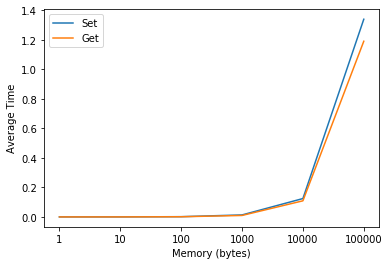

In [327]:
plt.plot(np.array(list(memory_set.keys())),np.array(list(memory_set.values())))
plt.plot(np.array(list(memory_get.keys())),np.array(list(memory_get.values())))
plt.xlabel("Memory (bytes)")
plt.ylabel("Average Time")
plt.legend(["Set","Get"])
plt.show()

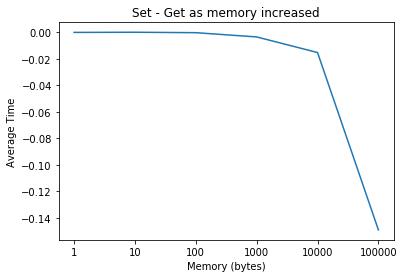

In [328]:
plt.plot(np.array(list(memory_get.keys())),np.array(list(memory_get.values()))-np.array(list(memory_set.values())))
plt.xlabel("Memory (bytes)")
plt.ylabel("Average Time")
plt.title("Set - Get as memory increased")
plt.show()

C:\Users\lpott\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  # Remove the CWD from sys.path while we load stuff.


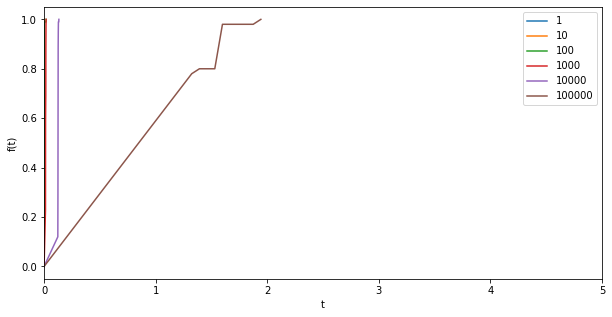

In [335]:
plt.figure(figsize=(10,5))


for size in job_size:
    key = size
    
    t = time_table_set[str(key)]

    num_bins = int(np.sqrt(len(t))) #int(np.floor(5/3 * (len(t)**(1/3))))
    counts, bin_edges = np.histogram (t, bins=num_bins, normed=True)
    cdf = np.cumsum (counts)
    plt.plot (np.hstack((np.zeros((1,)),bin_edges[1:])), np.hstack((np.zeros(1,),cdf/cdf[-1])))
    plt.xlabel("t"); plt.ylabel("f(t)");
    
    

plt.xlim([0,5])
plt.legend(job_size)
plt.show()


C:\Users\lpott\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  # Remove the CWD from sys.path while we load stuff.


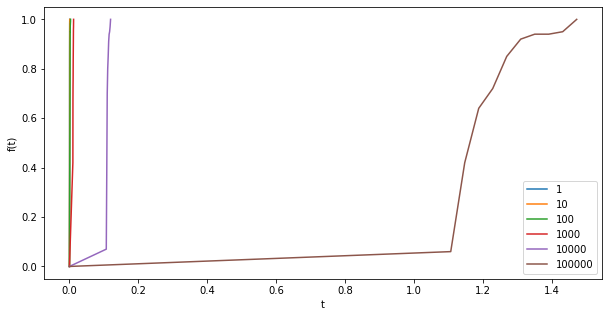

In [336]:
plt.figure(figsize=(10,5))


for size in job_size:
    key = size
    
    t = time_table_get[str(key)]

    num_bins = int(np.sqrt(len(t)))#int(np.floor(5/3 * (len(t)**(1/3))))
    counts, bin_edges = np.histogram (t, bins=num_bins, normed=True)
    cdf = np.cumsum (counts)
    plt.plot (np.hstack((np.zeros((1,)),bin_edges[1:])), np.hstack((np.zeros(1,),cdf/cdf[-1])))
    plt.xlabel("t"); plt.ylabel("f(t)");
    
    

plt.xlim()
plt.legend(job_size)
plt.show()

In [337]:
# clear keys
for i in range(N):
    r.delete("{0:015b}".format(i))